In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import os

import numpy as np
import matplotlib.pyplot as plt

from NormalizingFlows.src.train import train_backward
from NormalizingFlows.src.scores import log_likelihood
from NormalizingFlows.src.utils import update_device, load_best_model, load_checkpoint_model

from NormalizingFlows.src.flows import *
from NormalizingFlows.src.data.density.toydata import ToyDataset

In [3]:
def set_visible_devices(*devices: int) -> None:
    '''Utility to set visible Cuda devices.

    Parameters
    ----------
    devices : List[int]
        Index of cuda devices to make available for use.
    '''
    assert all([d >= 0 for d in devices]), f"Not all devices are CUDA devices!"
    os.environ['CUDA_VISIBLE_DEVICES'] = ",".join([str(i) for i in devices])
    

def set_devices(*devices: int):
    '''Utility to set Cuda device(s).

    Parameters
    ----------
    devices : List[int]
        Index of cuda devices to make available for use.

    Returns
    -------
    torch.device or List[torch.device] of currently available CUDA devices.
    '''
    assert len(devices) > 0, f'Device list is empty, no devices set.'
    if len(devices) == 1:
        if devices[0] >= 0:
            set_visible_devices(devices[0])
            return torch.device(0)
        else:
            return torch.device('cpu')

    else:
        set_visible_devices(*devices)
        return [torch.device(i) for i in range(len(devices))]

In [4]:
device = set_devices(1) #torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device_cpu = torch.device("cpu")

In [5]:
dim_input = 25
dataset = ToyDataset(dim_input=dim_input, samples=1000)

In [6]:
dim_input = dataset.dim_input
num_trans = 6 #Must be even
perm_types = ['identity', 'alternate','random']
dim_hidden = [100,100,100]
flows, names = [], []
flow_forward=False

In [7]:
#Linear and mean field

transformations = create_constant_trans(num_trans, dim_input, flow_forward)
mean_field = create_flows_with_identity(dim_input, transformations, flow_forward) 
name = 'Mean field'
flows.append(mean_field), names.append(name)

transformations = create_linear_bias_trans(num_trans, dim_input, flow_forward)
linear = create_flows_with_identity(dim_input, transformations, flow_forward)
name = 'Linear'
flows.append(linear), names.append(name);

In [8]:
# #Affine flows with two block

# transformations = create_affine_trans(num_trans, dim_input, flow_forward)
# aff_coup_id = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'Affine coupling identity'
# flows.append(aff_coup_id), names.append(name)

# transformations = create_affine_trans(num_trans, dim_input, flow_forward)
# aff_coup_alt = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'Affine coupling alternating'
# flows.append(aff_coup_alt), names.append(name)

# transformations = create_affine_trans(num_trans, dim_input, flow_forward)
# aff_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Affine coupling random'
# flows.append(aff_coup_rand), names.append(name);

In [9]:
# #Affine flows with AR

# transformations = create_affine_trans(num_trans, dim_input, flow_forward)
# aff_ar_id = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'Affine AR identity'
# flows.append(aff_ar_id), names.append(name)

# transformations = create_affine_trans(num_trans, dim_input, flow_forward)
# aff_ar_alt = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'Affine AR alternate'
# flows.append(aff_ar_alt), names.append(name)

# transformations = create_affine_trans(num_trans, dim_input, flow_forward)
# aff_ar_rand = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Affine AR random'
# flows.append(aff_ar_rand), names.append(name);

In [10]:
# #PiecewiseAffine flows with coupling

# transformations = create_piecewise_trans(num_trans, flow_forward)
# piec_coup_id = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'PiecewiseAffine coupling identity'
# flows.append(piec_coup_id), names.append(name)

# transformations = create_piecewise_trans(num_trans, flow_forward)
# piec_coup_alt = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'PiecewiseAffine coupling alternate'
# flows.append(piec_coup_alt), names.append(name)

# transformations = create_piecewise_trans(num_trans, flow_forward)
# piec_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'PiecewiseAffine coupling random'
# flows.append(piec_coup_rand), names.append(name);

In [11]:
# #PiecewiseAffine flows with AR

# transformations = create_piecewise_trans(num_trans, flow_forward)
# piec_ar_id = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'PiecewiseAffine AR identity'
# flows.append(piec_ar_id), names.append(name)

# transformations = create_piecewise_trans(num_trans, flow_forward)
# piec_ar_alt = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'PiecewiseAffine AR alternate'
# flows.append(piec_ar_alt), names.append(name)

# transformations = create_piecewise_trans(num_trans, flow_forward)
# piec_ar_rand = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'PiecewiseAffine AR random'
# flows.append(piec_ar_rand), names.append(name);

In [12]:
# #PiecewiseAffineAffine with twoblock

# transformations = create_affinepiecewise_trans(num_trans, flow_forward)
# piecaf_coup_id = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'PiecewiseAffineAffine coupling identity'
# flows.append(piecaf_coup_id), names.append(name)

# transformations = create_affinepiecewise_trans(num_trans, flow_forward)
# piecaf_coup_alt = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'PiecewiseAffineAffine coupling alternate'
# flows.append(piecaf_coup_alt), names.append(name)

# transformations = create_affinepiecewise_trans(num_trans, flow_forward)
# piecaf_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'PiecewiseAffineAffine coupling random'
# flows.append(piecaf_coup_rand), names.append(name);

In [13]:
# #PiecewiseAffineAffine with AR

# transformations = create_affinepiecewise_trans(num_trans, flow_forward)
# piecaf_ar_id = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'PiecewiseAffineAffine AR identity'
# flows.append(piecaf_ar_id), names.append(name)

# transformations = create_affinepiecewise_trans(num_trans, flow_forward)
# piecaf_ar_alt = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'PiecewiseAffineAffine AR alternate'
# flows.append(piecaf_ar_alt), names.append(name)

# transformations = create_affinepiecewise_trans(num_trans, flow_forward)
# piecaf_ar_rand = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'PiecewiseAffineAffine AR random'
# flows.append(piecaf_ar_rand), names.append(name);

In [14]:
# #ContinuousPiecewise with twoblock

# transformations = create_continuous_piecewise_trans(num_trans, flow_forward)
# conpiec_coup_iden = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'ContinuousPiecewiseAffine coupling identity'
# flows.append(conpiec_coup_iden), names.append(name)

# transformations = create_continuous_piecewise_trans(num_trans, flow_forward)
# conpiec_coup_alt = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'ContinuousPiecewiseAffine coupling alternate'
# flows.append(conpiec_coup_alt), names.append(name)

# transformations = create_continuous_piecewise_trans(num_trans, flow_forward)
# conpiec_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'ContinuousPiecewiseAffine coupling random'
# flows.append(conpiec_coup_rand), names.append(name);

In [15]:
# #ContinuousPiecewise with AR

# transformations = create_continuous_piecewise_trans(num_trans, flow_forward)
# conpiec_ar_iden = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'ContinuousPiecewiseAffine AR identity'
# flows.append(conpiec_ar_iden), names.append(name)

# transformations = create_continuous_piecewise_trans(num_trans, flow_forward)
# conpiec_ar_alt = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'ContinuousPiecewiseAffine AR alternate'
# flows.append(conpiec_ar_alt), names.append(name)

# transformations = create_continuous_piecewise_trans(num_trans, flow_forward)
# conpiec_ar_rand = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'ContinuousPiecewiseAffine AR random'
# flows.append(conpiec_ar_rand), names.append(name);

In [16]:
# #ContinuousPiecewiseAffine with twoblock

# transformations = create_affinecontinuous_trans(num_trans, flow_forward)
# affconpiec_coup_iden = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'ContinuousPiecewiseAffineAffine coupling identity'
# flows.append(affconpiec_coup_iden), names.append(name)

# transformations = create_affinecontinuous_trans(num_trans, flow_forward)
# affconpiec_coup_alt = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'ContinuousPiecewiseAffineAffine coupling alternate'
# flows.append(affconpiec_coup_alt), names.append(name)

# transformations = create_affinecontinuous_trans(num_trans, flow_forward)
# affconpiec_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'ContinuousPiecewiseAffineAffine coupling random'
# flows.append(affconpiec_coup_rand), names.append(name);

In [17]:
# #ContinuousPiecewiseAffine with AR

# transformations = create_affinecontinuous_trans(num_trans, flow_forward)
# affconpiec_ar_iden = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'ContinuousPiecewiseAffineAffine AR identity'
# flows.append(affconpiec_ar_iden), names.append(name)

# transformations = create_affinecontinuous_trans(num_trans, flow_forward)
# affconpiec_ar_alt = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[1], flow_forward)
# name = 'ContinuousPiecewiseAffineAffine AR alternate'
# flows.append(affconpiec_ar_alt), names.append(name)

# transformations = create_affinecontinuous_trans(num_trans, flow_forward)
# affconpiec_ar_rand = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'ContinuousPiecewiseAffineAffine AR random'
# flows.append(affconpiec_ar_rand), names.append(name);

In [18]:
# #Alternating Piecewise Affine with twoblock

# transformations = create_alt_piecewise_affine_trans(num_trans, flow_forward)
# afpiec_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Affin_PiecewiseAffine coupling random'
# flows.append(afpiec_coup_rand), names.append(name);

In [19]:
# #Alternating Piecewise Affine with AR

# transformations = create_alt_piecewise_affine_trans(num_trans, flow_forward)
# afpiec_ar_rand = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Affin_PiecewiseAffine AR random'
# flows.append(afpiec_ar_rand), names.append(name);

In [20]:
# #Alternating with Linear layer and Affine

# transformations = create_alt_linear_affine_trans(num_trans, dim_input, flow_forward)
# linaff_coup_iden = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'Alternating Linear_Affine coupling identity'
# flows.append(linaff_coup_iden), names.append(name)

# transformations = create_alt_linear_affine_trans(num_trans, dim_input, flow_forward)
# linaff_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Linear_Affine coupling random'
# flows.append(linaff_coup_rand), names.append(name)

# transformations = create_alt_linear_affine_trans(num_trans, dim_input, flow_forward)
# linaff_ar_iden = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[0], flow_forward)
# name = 'Alternating Linear_Affine AR identity'
# flows.append(linaff_ar_iden), names.append(name)

# transformations = create_alt_linear_affine_trans(num_trans, dim_input, flow_forward)
# linaff_ar_rand = create_flows_with_AR(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Linear_Affine AR random'
# flows.append(linaff_ar_rand), names.append(name);

In [21]:
# #Various Alternating Linear and Conditioner transformation

# transformations = create_alt_linear_piecewise_trans(num_trans, dim_input, flow_forward)
# linpiece_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Linear_PiecewiseAffine coupling random'
# flows.append(linpiece_coup_rand), names.append(name)

# transformations = create_alt_linear_continuous_trans(num_trans, dim_input, flow_forward)
# lincont_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Linear_ContinuousPiece coupling random'
# flows.append(lincont_coup_rand), names.append(name)

# transformations = create_alt_linear_affinepiecewise_trans(num_trans, dim_input, flow_forward)
# linaffpiec_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Linear_AffinePiece coupling random'
# flows.append(linaffpiec_coup_rand), names.append(name)

# transformations = create_alt_linear_affinecontinuous_trans(num_trans, dim_input, flow_forward)
# linaffcont_coup_rand = create_flows_with_twoblock(dim_input, dim_hidden, transformations, perm_types[2], flow_forward)
# name = 'Alternating Linear_AffineContinuous coupling random'
# flows.append(linaffcont_coup_rand), names.append(name);

In [22]:
for ind, flow in enumerate(flows):
    flow.name = names[ind]

In [23]:
losses = []
optimizers = []

epochs = 100
batch_size = 32

In [24]:
for i in range(len(flows)):
    flow = flows[i]
    update_device(device, flow, dataset)

    #optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3, weight_decay=1e-3)
    optimizer = torch.optim.SGD(flow.parameters(), lr=1e-4,  weight_decay=1e-3)
    optimizers.append(optimizer)

    losses.append(train_backward(flow, dataset.get_training_data(), optimizer, epochs, batch_size, print_n=200, save_checkpoint=True, burn_in=-1))
    update_device(device_cpu, flow, dataset)

Finished training. Loss for last epoch Linear:     62.77375


In [25]:
best_flows = []
for flow in flows:
    best_flows.append(load_best_model(flow))

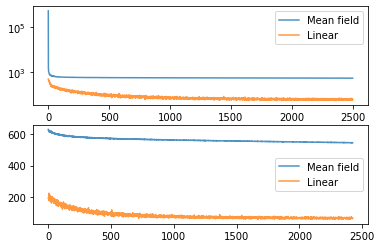

In [26]:
log_scale = True
from_iter = 75

plt.subplot(2,1,1)
for i in range(len(losses)):
    plt.plot(losses[i], label=names[i], alpha=0.8)
plt.legend()
if log_scale:
    plt.yscale('log')

log_scale = False
plt.subplot(2,1,2)
for i in range(len(losses)):
    plt.plot((losses[i])[from_iter:], label=names[i], alpha=0.8)
plt.legend()

if log_scale:
    plt.yscale('log')

In [27]:
print('Results based on training data:' + '\n')

train_data = dataset.get_training_data()
mean_target = torch.mean(dataset.evaluate(train_data.to(device))).detach().numpy()
for flow in best_flows:
    log_lik, mean = log_likelihood(train_data, flow)
    print("Mean loglikelihood for {}: {}".format(str(flow), mean))
    print("Difference between target and {} mean loglikelihood: {}".format(str(flow), abs(mean-mean_target)))
    

print("Mean loglikelihood with actual distribution: {}".format(mean_target))

Results based on training data:

Mean loglikelihood for Mean field: [-546.31464]
Difference between target and Mean field mean loglikelihood: [499.51196]
Mean loglikelihood for Linear: [-62.689957]
Difference between target and Linear mean loglikelihood: [15.887272]
Mean loglikelihood with actual distribution: -46.80268478393555


In [28]:
print('Results based on test data' + '\n')

test_data = dataset.get_test_data()
mean_target = torch.mean(dataset.evaluate(test_data)).detach().numpy()
for flow in best_flows:
    log_lik, mean = log_likelihood(test_data, flow)
    print("Mean loglikelihood for {}: {}".format(str(flow), mean))
    print("Difference between target and {} mean loglikelihood: {}".format(str(flow), abs(mean-mean_target)))
    

print("Mean loglikelihood with actual distribution: {}".format(mean_target))

Results based on test data

Mean loglikelihood for Mean field: [-546.6821]
Difference between target and Mean field mean loglikelihood: [500.12665]
Mean loglikelihood for Linear: [-64.25369]
Difference between target and Linear mean loglikelihood: [17.698196]
Mean loglikelihood with actual distribution: -46.55549621582031


In [39]:
print('Results based on new sample from each flow:' + '\n')

for flow in best_flows:
    with torch.no_grad():
        sample, log_prob = flow.sample(800)
        sample_last = sample[-1]
    
    sample_last.clip_(-7, 7)
    mean_target = torch.mean(dataset.evaluate(sample_last)).detach().numpy()
    log_lik, mean = log_likelihood(sample_last, flow)

    print('Check for NANs: ', torch.isnan(sample_last).any().item())
    print("Mean loglikelihood for {}: {}".format(str(flow), mean))
    print("Difference between target and {} mean loglikelihood: {}".format(str(flow), abs(mean-mean_target)))    
    print("Mean loglikelihood with actual distribution: {}".format(mean_target))   

Results based on new sample from each flow:

Check for NANs:  False
Mean loglikelihood for Mean field: [-540.7374]
Difference between target and Mean field mean loglikelihood: [277.01517]
Mean loglikelihood with actual distribution: -263.7222595214844
Check for NANs:  False
Mean loglikelihood for Linear: [-33.99629]
Difference between target and Linear mean loglikelihood: [5.2545013]
Mean loglikelihood with actual distribution: -39.250789642333984
